
    1. Break both images into subimages of size mxm.
    
    2. Mean subtraction from all the subimages.
    
    3. Attach respective sub-images side-by-side.
    
    4. Apply SVD(returns = U, S, V_trans).
    
    5. P = S * V_trans(size = mxn)
    
    6. Divide P into two parts(PR, PD), each of size (mxm)
    
    7. Calculate ds(j) on each column vector of PR and PD
    
    8. Calculate dl(i) for all the subimages' ds(i)
    
    9. Take mean of dl(i)
    
    10. Result is the score we wanted

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab.patches import cv2_imshow
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [10, 10]

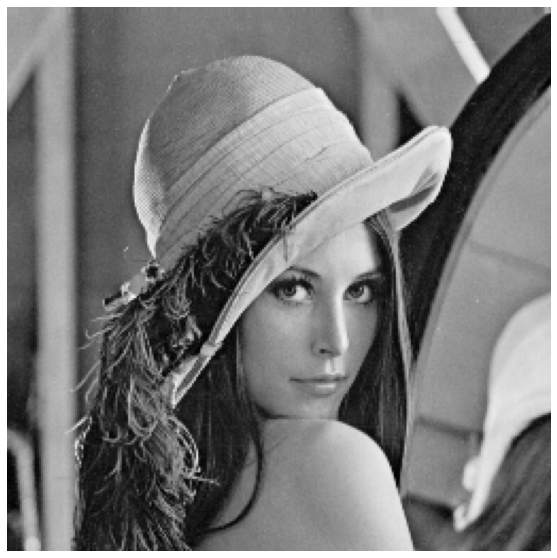

In [ ]:
org_image = plt.imread("/content/drive/MyDrive/CT_11/lena_gray_512.tif")
plt.imshow(dis_image, "gray")
plt.axis("off")
plt.show()

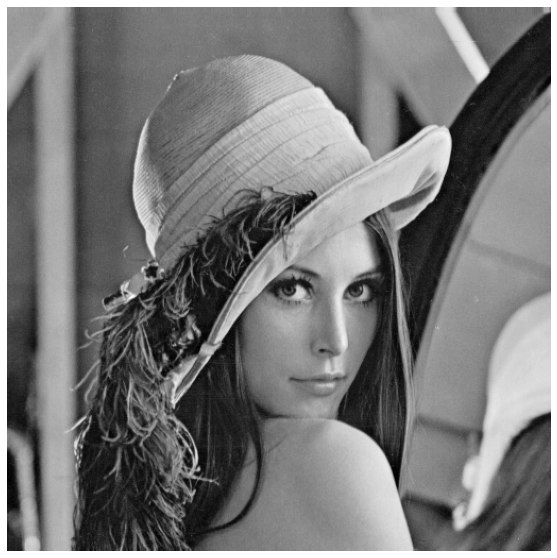

In [ ]:
dis_image = plt.imread("/content/drive/MyDrive/CT_11/lena_gray_256.tif")
plt.imshow(org_image, "gray")
plt.axis("off")
plt.show()

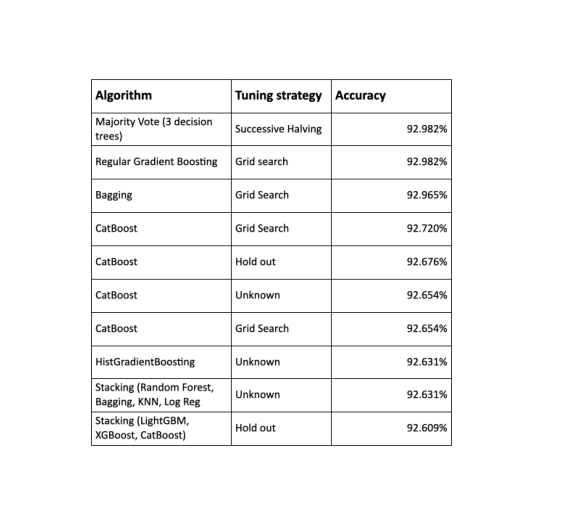

In [ ]:
diff_image = plt.imread("/content/drive/MyDrive/CT_11/FEVUbLjXwAQDcMj.png")
diff_image = diff_image[: , :, 0]
plt.imshow(diff_image, "gray")
plt.axis("off")
plt.show()

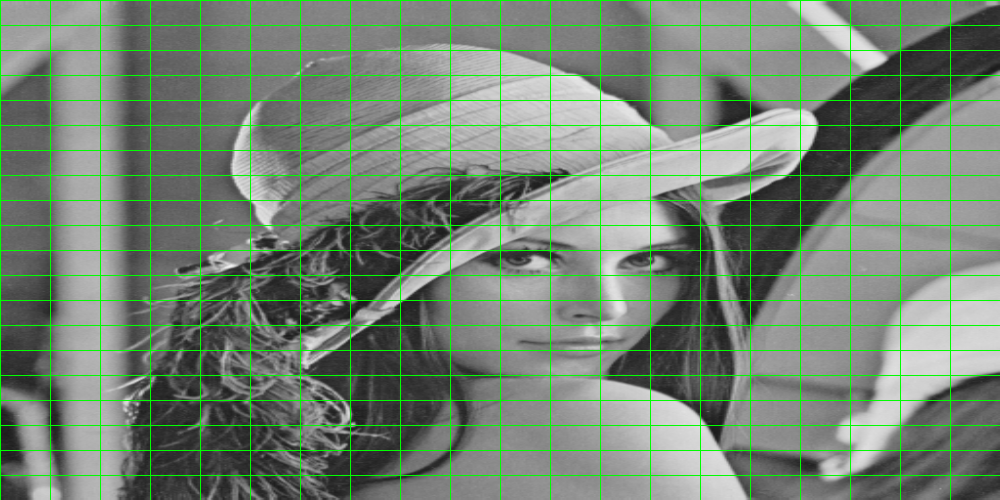

In [ ]:
im = cv2.imread("/content/drive/MyDrive/CT_11/lena_gray_512.tif")
im = cv2.resize(im,(1000,500))

imgheight = im.shape[0]
imgwidth = im.shape[1]

y1 = 0
M = imgheight//20
N = imgwidth//20

for y in range(0,imgheight,M):
    for x in range(0, imgwidth, N):
        y1 = y + M
        x1 = x + N
        tiles = im[y:y+M,x:x+N]

        cv2.rectangle(im, (x, y), (x1, y1), (0, 255, 0))
        cv2.imwrite("save/" + str(x) + '_' + str(y)+".png",tiles)

cv2_imshow(im)

In [ ]:
print(org_image.shape, dis_image.shape)
org_image = np.array(resize(org_image, (256, 256)))
dis_image = np.array(resize(dis_image, (256, 256)))
diff_image = np.array(resize(diff_image, (256, 256)))
print(org_image.shape, dis_image.shape)

(512, 512) (256, 256)
(256, 256) (256, 256)


In [ ]:
def break_image(image1 = org_image, image2 = dis_image, m = 4):
    ds_main = np.array([])
    subimage_count = int(len(image1)//m)*2
    for i in range(len(image1)//m):
        for j in range(len(image1)//m):
            subimage1 = image1[i:i+m, j:j+m]
            subimage2 = image2[i:i+m, j:j+m]
            
            def subtract_mean(image):
                image = image - image.mean()
                return image
        
            org_image = subtract_mean(subimage1)
            dis_image = subtract_mean(subimage2)
            
            def attach_images(image1, image2):
                new_image = np.concatenate((image1, image2), axis = 1)
                return new_image
        
            attached_image = attach_images(org_image, dis_image)
            
            _, S, V_trans = np.linalg.svd(attached_image, full_matrices = False)
            P = np.diag(S) @ V_trans
            PR, PD = np.split(P, 2, axis = 1)
            
            def calculate_ds(mat1 = PR, mat2 = PD):
                ds = []
                for i in range(len(mat1)):
                    l3_1 = sum(mat1[:, i]**2)**(1/3)
                    l3_2 = sum(mat2[:, i]**2)**(1/3)
                    ds += (l3_1 - l3_2),
                return ds
            ds_main = np.append(ds_main, np.array(calculate_ds()))
    return ds_main, subimage_count

In [ ]:
def calculate_dl(ds):
    dl = []
    for i in range(subimage_count):
        ds_sub = np.split(ds, subimage_count)[i]
        mds = sum(ds_sub)/len(ds_sub)
        dl += ((sum((ds_sub-mds)**2))/len(ds_sub))**0.5,
    return np.array(dl)



In [ ]:
ds_main_mid, subimage_count = break_image()
dl_mid = calculate_dl(ds_main_mid)
score_mid = sum(dl_mid)/len(dl_mid)
print("Score for Reference and distorted images: ", score_mid)

Score for Reference and distorted images:  0.02202721881638776


In [ ]:
ds_main_same, subimage_count = break_image(org_image, org_image, 16)
dl_same = calculate_dl(ds_main_same)
score_same = sum(dl_same)/len(dl_same)
print("Score for same images: ", score_same)

Score for same images:  4.1591374695965026e-17


In [ ]:
ds_main_diff, subimage_count = break_image(org_image, diff_image, 16)
dl_diff = calculate_dl(ds_main_diff)
score_diff = sum(dl_diff)/len(dl_diff)
print("Score for totally different images: ", score_diff)

Score for totally different images:  0.0676286731789097
